### target prop in scalar network

In [ ]:
%reset -f
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [ ]:
# add biases?

# parameters...
batches = 9
t_steps = 40
algs = 4
layers = 2

alpha = 0.1

# target function
T = 2

#forward weights
w = np.zeros((algs, t_steps, layers, batches))
dw = np.zeros((algs, t_steps, layers, batches))

#feedback weights
b = np.zeros((algs, t_steps, layers, batches))

#activations
x = np.zeros((algs, t_steps, layers+1, batches))
dx = np.zeros((algs, t_steps, layers+1, batches))

# Notes:
# x[-1] = yhat
# dx[-1] = e = yhat - y

# target output
y = np.zeros((algs, batches))

# Initialize...
for k in range(algs):
    w[k, 0, 0, :] = -0.5*np.ones(batches)
    w[k, 0, 1, :] = 0.2*np.ones(batches)
#     b[k, 0, 0, :] = 0*np.ones(batches)
#     b[k, 0, 1, :] = 0*np.ones(batches)
    for t in range(t_steps):
        x[k, t, 0, :] = np.linspace(-2, 2, batches)
        y[k, :] = T*x[k, t, 0, :]

# Training
for t in range(t_steps):
    for k in range(algs):
        # forward pass
        x[k, t, 1, :] = w[k, t, 0, :]*x[k, t, 0, :]
        x[k, t, 2, :] = w[k, t, 1, :]*x[k, t, 1, :]
        
        dx[k, t, 2, :] = x[k, t, 2, :] - y[k, :]
        
        if k == 0:
            dx[k, t, 1, :] = w[k, t, 1, :]*dx[k, t, 2, :]
            
        elif k == 1:
            dx[k, t, 1, :] = .1*dx[k, t, 2, :]
        elif k == 2:
            dx[k, t, 1, :] = x[k, t, 1, :] + 1/w[k, t, 1, :]*dx[k, t, 2, :] - 1/w[k, t, 1, :]*x[k, t, 2, :]
        elif k == 3:
            dx[k, t, 1, :] = 1/w[k, t, 1, :]*dx[k, t, 2, :]
                
        dw[k, t, 1, :] = -alpha*dx[k, t, 2, :]*x[k, t, 1, :]
        dw[k, t, 0, :] = -alpha*dx[k, t, 1, :]*x[k, t, 0, :]

        if t != t_steps-1:
            w[k, t+1, 0, :] = w[k, t, 0, :] + dw[k, t, 0, :]
            w[k, t+1, 1, :] = w[k, t, 1, :] + dw[k, t, 1, :]

In [ ]:
batch = 2
k = 0
plt.figure(figsize=(12,6))

# lines
plt.plot([0, 2], [0, 0], 'k', linewidth=1, alpha=0.3)
plt.plot([0, 0], [-3, 3], 'k', linewidth=1, alpha=0.3)
plt.plot([1, 1], [-3, 3], 'k', linewidth=1, alpha=0.3)
plt.plot([2, 2], [-3, 3], 'k', linewidth=1, alpha=0.3)

# activations
plt.plot([0, 1, 2], x[k, 0, :, batch],'-o', color=sns.color_palette()[0], linewidth=0.5, markersize=10, alpha=1)
for t in range(1,t_steps):
    plt.plot([0, 1, 2], x[k, t, :, batch],'-o', color=sns.color_palette()[0], linewidth=0.5, markersize=10, alpha=0.3)

# target
plt.plot([2], y[k, batch],'o', color=sns.color_palette()[1], markersize=10)

# Errors
plt.plot([1, 2], dx[k, 0, 1:3, batch], '-o', color=sns.color_palette()[2], linewidth=0.5, markersize=10)
for t in range(1,t_steps):
    plt.plot([1, 2], dx[k, t, 1:3, batch], '-o', color=sns.color_palette()[2], linewidth=0.5, markersize=10, alpha=0.3)

plt.xlim(-0.5, 2.5)
plt.ylim(-3.5, 3.5)
plt.show()

plt.figure(figsize=(3,3))
plt.plot(np.linspace(-2.5,0,50), T/np.linspace(-2.5,0,50), 'k', linewidth=1, alpha=0.5)
plt.plot(np.linspace(0,2.5,50), T/np.linspace(0,2.5,50), 'k', linewidth=1, alpha=0.5)

plt.plot(w[k, 0, 0, batch], w[k, 0, 1, batch], 'o', color=sns.color_palette()[0])
for t in range(1,t_steps):
    plt.plot(w[k, t, 0, batch], w[k, t, 1, batch], 'o', color=sns.color_palette()[0], alpha=0.1)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.show()

### Target prop in a deep linear network

In [ ]:
%reset -f
%matplotlib inline

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
### 1d visualizations...

In [ ]:
def rank_one_matrix():
    ''' return: random 2x2 rank one matrix'''
    W_ = np.random.randn(2,2)
    u,s,v = np.linalg.svd(W_)
    return np.outer(u[:,0],v[0])

def simple_matrix():
    ''' return: a specific 2x2 rank one matrix '''
    return np.outer(np.array([1,0]), np.array([1,2])/np.linalg.norm([1,2]))

def get_subspaces(A_, r):
    ''' return: a dict containing the four fundamental subspaces of a matrix A '''
    u,s,v = np.linalg.svd(A_, full_matrices=True)
    ss = {'im': u[:,:r], 'ker': v[r:].T, 'coim': v[:r].T, 'coker': u[:,r:]}
    return ss

def plot_vecline(V, i=0, color=0):
    ''' plots the 1d subspace (line) spanned by one vector V '''
    VV = np.concatenate((-10*V, 10*V), axis=1)
    ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=2.0)
    
def plot_quotient(V, W, i=0, color=5):
    ''' plots elements (lines) of the quotient space V/W 
        todo: replace n with sv or 1/sv
    '''
    for n in np.arange(-3,3.1,0.5):
        VV = np.concatenate((-10*V, 10*V), axis=1)
        VV = VV + n*W
        ax[i].plot(VV[0], VV[1], color=sns.color_palette("RdBu_r",7)[color], linewidth=0.5)

def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5)
    fig.axes[i].axvline(0, color='w', linewidth=3.5)
    fig.axes[i].set_xlim(-3.5,3.5)
    fig.axes[i].set_ylim(-3.5,3.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])

In [ ]:
# Forward activation
def forward(x_init, W_in):
    ''' get activations for all neurons '''
    # TODO: show two+ vectors / batch learning.
    # batch learning: first then second vs second then first vs batch -- commutivity? 
    x_ = []
    x_.append(x_init)
    for l in range(layers):
        x_.append(np.dot(W_in[l], x_[-1]))
    return x_

In [ ]:
# Backprop
def backward(x_end, W_in):
    ''' get dL/dx[l] for all x '''
    dL_ = (layers+1)*[None]
    dL_[-1] = (x_end-y) # negative gradient of MSE
    for l in range(layers-1,-1,-1):
        dL_[l] = np.dot(W_in[l].T, dL_[l+1])
    return dL_

def train_weights(W_in, dL_in, x_in, alpha=.1):
    ''' get dL/dW[l] for all l '''
    W_ = np.copy(W_in)
    for l in range(layers):
        W_[l] = W_[l] - alpha*np.outer(dL_in[l+1], x_in[l])
    return W_

def get_W_update(dL_t_in, x_t_in):
    ''' get np.outer(dL[l+1], x[l]), the rank-one update for the weights in backprop. '''
    W_up = train_steps*[layers*[None]]
    W_up_ss = train_steps*[layers*[None]]
    for i in range(train_steps):
        for l in range(layers):
            W_up[i][l] = np.outer(dL_t_in[i][l+1], x_t_in[i][l])
            W_up_ss[i][l] = get_subspaces(W_up[i][l], 1)
    return W_up, W_up_ss

In [ ]:
# Target prop
def get_pinv(W_in):
    ''' get pinv '''
    W_pinv_ = layers*[None]
    for l in range(layers):
        W_pinv_[l] = np.linalg.pinv(W_in[l])
    return W_pinv_

def get_targets(x_in, W_in, dL_in):
    '''  '''
    x_tar_ = (layers+1)*[None]
    W_pinv_ = get_pinv(W_in)
    x_tar_[-1] = x_in[-1] - alpha*dL_in[-1]
    for l in range(layers-1,-1,-1):
        x_tar_[l] = x_in[l] - np.dot(W_pinv_[l], x_in[l+1]) + np.dot(W_pinv_[l],x_tar_[l+1])
    return x_tar_

def train_weights_targ(W_in, x_targ_in, x_in, alpha=.1):
    ''' train weights, targ prop version '''
    dL_local = [x_in[l] - x_targ_in[l] for l in range(len(x_in))]
    W_ = train_weights(W_in, dL_local, x_in, alpha=alpha)
    return W_

# Try pseudo-inverse to learn weights. Write a train_weights function
# for both backprop and target prop.

In [ ]:
# parameters...
batches = 121
t_steps = 100
algs = 4
layers = 2

alpha = 0.01

# target function
T = np.random.randn(2,2)/np.sqrt(2)

#forward weights
W = np.zeros((algs, t_steps, layers+1, batches), dtype=object)
dW = np.zeros((algs, t_steps, layers+1, batches), dtype=object)

#feedback weights
B = np.zeros((layers+1), dtype=object)

#activations
x = np.zeros((algs, t_steps, layers+1, batches), dtype=object)
dx = np.zeros((algs, t_steps, layers+1, batches), dtype=object)

# target output
y = np.zeros((batches), dtype=object)

# Initialize...
vv, hh = np.mgrid[-2:2:11j, -2:2:11j]
x_in = np.stack((vv.ravel(), hh.ravel()), axis=0)
B[2] = np.random.randn(2, 2)
for b in range(batches):
    for k in range(algs):
        W[k, 0, 1, b] = -0.1*np.ones((2,2))
        W[k, 0, 2, b] = 0.1*np.ones((2,2))
        for t in range(t_steps):        
            x[k, t, 0, b] = x_in[:,b]
    y[b] = np.dot(T, x_in[:,b])

# Training

for b in range(batches):
    for t in range(t_steps):
        for k in range(algs):
            # forward pass
            x[k, t, 1, b] = np.dot(W[k, t, 1, b], x[k, t, 0, b])
            x[k, t, 2, b] = np.dot(W[k, t, 2, b], x[k, t, 1, b])

            dx[k, t, 2, b] = x[k, t, 2, b] - y[b]

            if k == 0:
                dx[k, t, 1, b] = np.dot(W[k, t, 2, b].T, dx[k, t, 2, b])
            elif k == 1:
                dx[k, t, 1, b] = np.dot(B[2], dx[k, t, 2, b])
            elif k == 2:
                dx[k, t, 1, b] = x[k, t, 1, b] + np.dot(np.linalg.pinv(W[k, t, 2, b]), dx[k, t, 2, b]) - np.dot(np.linalg.pinv(W[k, t, 2, b]), x[k, t, 2, b])
            elif k == 3:
                dx[k, t, 1, b] = np.dot(np.linalg.pinv(W[k, t, 2, b]), dx[k, t, 2, b])

            dW[k, t, 2, b] = -alpha*np.outer(dx[k, t, 2, b], x[k, t, 1, b])
            dW[k, t, 1, b] = -alpha*np.outer(dx[k, t, 1, b], x[k, t, 0, b])

            if t != t_steps-1:
                W[k, t+1, 1, b] = W[k, t, 1, b] + dW[k, t, 1, b]
                W[k, t+1, 2, b] = W[k, t, 2, b] + dW[k, t, 2, b]

In [ ]:
## ROW 1
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

b = 35
k = 1
for k in range(algs):
    for l in range(layers+1):
        ax[l].plot(x[k, 0, l, b][0], x[k, 0, l, b][1], 'o', markersize=12, color=sns.color_palette()[k])
        if l != 0:
            ax[l].plot(dx[k, 0, l ,b][0], dx[k, 0, l, b][1], '^', markersize=12, color=sns.color_palette()[k])
        for t in range(1, t_steps):
            ax[l].plot(x[k, t, l, b][0], x[k, t, l, b][1], 'o', markersize=8, alpha=0.1, color=sns.color_palette()[k])
            if l != 0:
                ax[l].plot(dx[k, t, l ,b][0], dx[k, t, l, b][1], '^', markersize=12, color=sns.color_palette()[k], alpha=0.1)
    
ax[-1].plot(y[b][0],y[b][1], 'o', markersize=15, color='k')
            
            
#plot_dots(ax)
#ax[-1].contour(hh, vv, L, 10)
plt.show()


In [ ]:
def plot_dots(ax_):
    for l in range(layers+1):
        for t in [c+1 for c in range(train_steps-2,-1,-1)]:
            ax_[l].plot(x_bp_t[t+1][l][0], x_bp_t[t+1][l][1], 'o', color=sns.color_palette()[0], ms=10, alpha=0.2)
            ax_[l].plot(dL_t[t+1][l][0], dL_t[t+1][l][1], 'o', color=sns.color_palette()[1], ms=10, alpha=0.2)
            ax_[l].plot(x_tp_t[t+1][l][0], x_tp_t[t+1][l][1], '*', color=sns.color_palette()[0], ms=10, alpha=0.5)
            ax_[l].plot(x_tar_t[t+1][l][0], x_tar_t[t+1][l][1], '*', color=sns.color_palette()[1], ms=10, alpha=0.5)

        ax_[l].plot(x_bp_t[0][l][0], x_bp_t[0][l][1], 'o', color=sns.color_palette()[0], ms=10)
        ax_[l].plot(dL_t[0][l][0], dL_t[0][l][1], 'o', color=sns.color_palette()[1], ms=10)
        ax_[l].plot(x_tp_t[0][l][0], x_tp_t[0][l][1], '*', color=sns.color_palette()[0], ms=10)
        ax_[l].plot(x_tar_t[0][l][0], x_tar_t[0][l][1], '*', color=sns.color_palette()[1], ms=10)
    ax_[-1].plot(y[0],y[1], '^', color=sns.color_palette()[4], ms=10)


In [ ]:
# construct model:
layers = 2
W = []
W_ss = []

train_steps = 50
alpha = .05

for l in range(layers):
    W.append(simple_matrix())
    W_ss.append(get_subspaces(W[l], 1))

# Data
x_0 = np.array([-1.5,-1.15])
y = np.array([1,0.5])
    
# Cost function visualization
vv, hh = np.mgrid[-2:2:20j, -2:2:20j]
L = 0.5*((hh-y[0])**2 + (vv-y[1])**2)

# First pass
x = forward(x_0, W)
dL = backward(x[-1], W)
x_tar = get_targets(x, W, dL)

# Training steps
x_bp_t = [x]
W_bp_t = [W]
dL_t = [dL]

x_tp_t = [x]
x_tar_t = [x_tar]
W_tp_t = [W]

# Training
for i in range(train_steps):
    # backprop
    W_bp_t.append(train_weights(W_bp_t[-1], dL_t[-1], x_bp_t[-1], alpha=alpha))
    x_bp_t.append(forward(x_0, W_bp_t[i]))
    dL_t.append(backward(x_bp_t[-1][-1], W_bp_t[-1]))
    
    # target prop
    W_tp_t.append(train_weights_targ(W_tp_t[-1], x_tar_t[-1], x_tp_t[-1], alpha=10*alpha))
    x_tp_t.append(forward(x_0, W_tp_t[i]))
    x_tar_t.append(get_targets(x_tp_t[-1], W_tp_t[-1], dL_t[-1]))

# pseudoinv
W_pi = []
W_ps = []
for i in range(train_steps+1):
    W_pi.append(get_pinv(W_tp_t[i]))
for l in range(layers):
    W_ps.append(get_subspaces(W_pi[0][l], 1))

In [ ]:
def plot_dots(ax_):
    for l in range(layers+1):
        for t in [c+1 for c in range(train_steps-2,-1,-1)]:
            ax_[l].plot(x_bp_t[t+1][l][0], x_bp_t[t+1][l][1], 'o', color=sns.color_palette()[0], ms=10, alpha=0.2)
            ax_[l].plot(dL_t[t+1][l][0], dL_t[t+1][l][1], 'o', color=sns.color_palette()[1], ms=10, alpha=0.2)
            ax_[l].plot(x_tp_t[t+1][l][0], x_tp_t[t+1][l][1], '*', color=sns.color_palette()[0], ms=10, alpha=0.5)
            ax_[l].plot(x_tar_t[t+1][l][0], x_tar_t[t+1][l][1], '*', color=sns.color_palette()[1], ms=10, alpha=0.5)

        ax_[l].plot(x_bp_t[0][l][0], x_bp_t[0][l][1], 'o', color=sns.color_palette()[0], ms=10)
        ax_[l].plot(dL_t[0][l][0], dL_t[0][l][1], 'o', color=sns.color_palette()[1], ms=10)
        ax_[l].plot(x_tp_t[0][l][0], x_tp_t[0][l][1], '*', color=sns.color_palette()[0], ms=10)
        ax_[l].plot(x_tar_t[0][l][0], x_tar_t[0][l][1], '*', color=sns.color_palette()[1], ms=10)
    ax_[-1].plot(y[0],y[1], '^', color=sns.color_palette()[4], ms=10)


In [ ]:
## ROW 1
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for l in range(layers):
    plot_quotient(W_ss[l]['ker'], W_ss[l]['coim'], l)
    plot_vecline(W_ss[l]['ker'], l, -1)
    plot_vecline(W_ss[l]['coim'],l, 1)

plot_dots(ax)
ax[-1].contour(hh, vv, L, 10)
plt.show()

## ROW 2
fig, ax = plt.subplots(1, layers+1, figsize=(20,20))
for l in range(layers+1):
    square_axes(l)

for l in range(layers):
    plot_quotient(W_ss[l]['coker'], W_ss[l]['im'], l+1)
    plot_vecline(W_ss[l]['coker'], l+1, -1)
    plot_vecline(W_ss[l]['im'],l+1, 1)

plot_dots(ax)
plt.show()

- W[l] moves in the direction to minimize error.
- Does this imply that x[l] also moves in the direction to minimize error?


- Specify the space of possible solutions -- global sections of x[l], but also space of W[l]?


- visualize the gradient functionals 


- Understand why for backprop:
    - dL/dW does not change over training steps (uh, maybe a bug?)
    - dL/dW is specifically rank-one. What is gained by higher-rank updates. Relation to FORCE / RLS / Full-FORCE. Newton's method -> higher thank rank-one?
    

- should be able to prove why W_update is constant for deep linear networks. Implications?


- confirm: does x[t] + alpha*dL/dx[t] = x[t] + alpha*(x_prevlayer[t])

dL/dx[l] says: move in this direction to reduce error. And dL/dW[l] says: 


- idea: plot loss contours at each layer -- i.e. backprop the entire error function... (?)


- more generally: play with visualizations for images, kernel, preimage, etc.

In [ ]:
x_array = np.array(x_tp_t)
dL_array = np.array(dL_t)
W_array = np.array(W_tp_t)
#W_update_array = np.array(W_update)

In [ ]:
fig, ax = plt.subplots(1, layers+1, figsize=(20,4))
for l in range(layers+1):
    ax[l].plot(x_array[:,l,:])
    ax[l].plot(dL_array[:,l,:],'--')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, layers, figsize=(20,4))
for l in range(layers):
    ax[l].plot(W_array[:,l,:,0])
    ax[l].plot(W_array[:,l,:,1])
    #ax[l].plot(W_update_array[:,l,:,0],'--')
    #ax[l].plot(W_update_array[:,l,:,1],'--')
plt.show()

In [7]:
# sigmoid...
%reset -f
%matplotlib inline
import numpy as np  
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

In [185]:
def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].axvline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].set_xlim(-1.5,1.5)
    fig.axes[i].set_ylim(-1.5,1.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])

def get_matrix(layer=1):
    if layer == 1:
        A = np.array([[0.1, 0],[0.9, 1]])
    else:
        A = np.array([[1, 0.9],[0, 1]])
    return A
def get_bias(layer=1):
    if layer == 1:
        b = np.array([[0],[0]])
    else:
        b = np.array([[0],[0]])
    return b
def f1(x,layer):
    return np.dot(get_matrix(layer), x) + get_bias(layer)
def f1_inv(x,layer):
    A = get_matrix(layer)
    return np.dot(np.linalg.inv(A), x - get_bias(layer))
def f2(x):
    return 2./(1 + np.exp(-x))-1
def f2_inv(x):
    return -np.log(2./(1+x) - 1)

def df2(x):
    return (1 - f2(x)**2)*x
def df1(x, layer):
    return np.dot(get_matrix(layer).T, x)

def relu(x):
    return x*(x>0)

def get_preimg(img, func, eps=0.1):
    """ computes the preimage a of set img through func, i.e.
        img=func(a)"""
    c1 = np.linspace(-2, 2, 201)
    c2 = np.linspace(-2, 2, 201)
    x1, y1 = np.meshgrid(c1, c2)
    a = np.stack((x1.flatten(), y1.flatten()))
    d = np.zeros(a.shape[1])
    b = func(a)
    for i in range(a.shape[1]):
        d[i] = np.min(np.linalg.norm(b[:,i] - img))
    inds = d < eps
    return a[:,inds], b[:,inds]

def get_circle(center, radius, points=100):
    x = radius*np.cos(np.linspace(0, 2*np.pi, num=points)) + center[0]
    y = radius*np.sin(np.linspace(0, 2*np.pi, num=points)) + center[1]
    return np.stack((x,y))

def prop(init, L=1):
    x = []
    x.append(init)
    for l in range(1, L+1):
        x.append(f1(x[-1], l))
        x.append(f2(x[-1]))
    return x
def back(init, L=1):
    y = []
    y.append(init)
    for l in range(L, 0, -1):
        y.append(f2_inv(y[-1]))
        y.append(f1_inv(y[-1], l))
    y.reverse()
    return y
def bprop(init, L=1):
    d = []
    d.append(init)
    for l in range(L, 0, -1):
        d.append(df2(d[-1]))
        d.append(df1(d[-1], l))
    d.reverse()
    return d

In [186]:
L=2

In [187]:
# Grid lines
c1 = np.linspace(-5, 5, 101)
c2 = np.linspace(-5, 5, 11)
x1, y1 = np.meshgrid(np.append(c1, 999), c2)
x2, y2 = np.meshgrid(np.append(c1, 999), c2)
x1[x1==999] = None
y1[y1==999] = None
x2[x2==999] = None
y2[y2==999] = None

# just grid lines
a1 = prop(np.stack((x1.flatten(), y1.flatten())), L=L)
a2 = prop(np.stack((y2.flatten(), x2.flatten())), L=L)

In [188]:
# Vectors:
x = prop(np.array([[1],[1]]), L=L)
y = back(np.array([[-0.9],[-0]]), L=L)
xt= back(x[-1] - 0.5*(x[-1]-y[-1]), L=L)
dl = bprop(x[-1]-y[-1], L=L)

In [189]:
# Shapes:
circ = back(get_circle(y[-1], np.linalg.norm(x[-1] - y[-1])), L=L)
circ2 = back(get_circle(y[-1], 0.5*np.linalg.norm(x[-1] - y[-1])), L=L)
circ3 = back(get_circle(y[-1], 0.25*np.linalg.norm(x[-1] - y[-1])), L=L)
circ4 = back(get_circle(y[-1], 0.75*np.linalg.norm(x[-1] - y[-1])), L=L)

line = back(np.stack((np.linspace(x[-1][0], y[-1][0]), np.linspace(x[-1][1], y[-1][1]))), L=L)

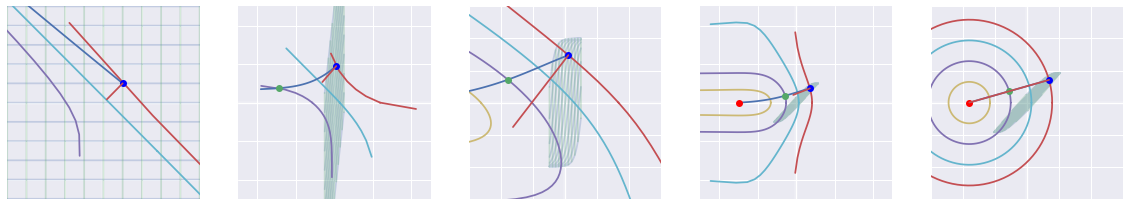

In [193]:
fig, ax = plt.subplots(1, 2*L+1, figsize=(20,20))
for i in range(2*L+1):
    square_axes(i)
    if i % 2 or i == 0:
        fig.axes[i].set_xlim(-5,5)
        fig.axes[i].set_ylim(-5,5)
    
for i in range(2*L+1):
    ax[i].plot(a1[i][0], a1[i][1], '-', alpha=0.25)
    ax[i].plot(a2[i][0], a2[i][1], '-', alpha=0.25)
    ax[i].plot(circ[i][0], circ[i][1])
    ax[i].plot(circ2[i][0], circ2[i][1])
    ax[i].plot(circ3[i][0], circ3[i][1])
    ax[i].plot(circ4[i][0], circ4[i][1])
    ax[i].plot(line[i][0], line[i][1])
    ax[i].plot(x[i][0], x[i][1], 'bo')
    ax[i].plot(y[i][0], y[i][1], 'ro')
    ax[i].plot(xt[i][0], xt[i][1], 'o')
    ax[i].plot([x[i][0], x[i][0] - dl[i][0]], [x[i][1], x[i][1] - dl[i][1]])
plt.show()

In [123]:
def ff(x):
    return f2(f1(x, 1))

In [143]:
aa, bb = get_preimg(np.array([-0.8, 0]), ff, 0.5)

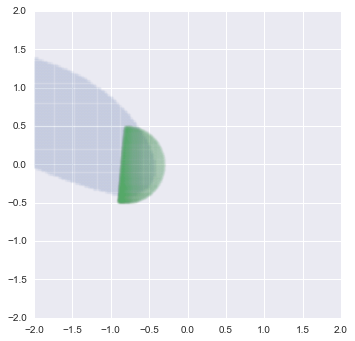

In [147]:
plt.figure()
plt.plot(aa[0,:], aa[1,:], '.', alpha=0.05)
plt.plot(bb[0,:], bb[1,:], '.', alpha=0.05)
plt.axis('square')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()